In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import seaborn as sns
# sns.set_style('whitegrid')

import covid19

PALETTE = sns.color_palette()

## data

In [3]:
data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
# data_italy_path = covid19.data.download('andamento-nazionale')

In [4]:
data_italy = pd.read_csv(data_italy_path, parse_dates=['data'], index_col=['data'])
data_italy.index = data_italy.index.normalize()

for column in ['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']:
    data_italy['variazione_' + column] = data_italy[column].diff(1)

data_italy.tail()

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,variazione_ricoverati_con_sintomi,variazione_terapia_intensiva,variazione_deceduti
data,,,,,,,,,,,,,,,,
2020-03-25,ITA,23112,3489,26601,30920,57521,3491,9362,7503,74386,324445,NaN,NaN,1175.0,93.0,683.0
2020-03-26,ITA,24753,3612,28365,33648,62013,4492,10361,8165,80539,361060,pd-IT-0007,pd-EN-0007,1641.0,123.0,662.0
2020-03-27,ITA,26029,3732,29761,36653,66414,4401,10950,9134,86498,394079,NaN,NaN,1276.0,120.0,969.0
2020-03-28,ITA,26676,3856,30532,39533,70065,3651,12384,10023,92472,429526,NaN,NaN,647.0,124.0,889.0
2020-03-29,ITA,27386,3906,31292,42588,73880,3815,13030,10779,97689,454030,pd-IT-0009,pd-EN-0009,710.0,50.0,756.0


## situation report

In [5]:
START_FIT = '2020-02-23'
STOP_FIT = '2020-03-29'
EXTRAPOLATE = (np.datetime64('2020-03-01'), np.datetime64('2020-03-31'))

In [6]:
fits = {}
fits['dimessi_guariti'] = covid19.fit.ExponentialFit.from_frame('dimessi_guariti', data_italy, start='2020-03-08', stop=STOP_FIT)
fits['totale_casi_1'] = covid19.fit.ExponentialFit.from_frame('totale_casi', data_italy, start=START_FIT, stop='2020-02-29')
fits['totale_casi'] = covid19.fit.ExponentialFit.from_frame('totale_casi', data_italy, start='2020-03-01', stop='2020-03-09')

fits['ricoverati_con_sintomi_1'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start=START_FIT, stop='2020-03-06')
fits['ricoverati_con_sintomi_2'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start='2020-03-08', stop='2020-03-19')
fits['ricoverati_con_sintomi_3'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start='2020-03-20', stop='2020-03-22')
fits['terapia_intensiva_1'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start=START_FIT, stop='2020-03-06')
fits['terapia_intensiva_2'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start='2020-03-07', stop='2020-03-13')
fits['terapia_intensiva_3'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start='2020-03-14', stop='2020-03-18')
fits['terapia_intensiva_4'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start='2020-03-19', stop='2020-03-24')
fits['deceduti_1'] = covid19.fit.ExponentialFit.from_frame('deceduti', data_italy, start=START_FIT, stop='2020-03-11')
fits['deceduti_2'] = covid19.fit.ExponentialFit.from_frame('deceduti', data_italy, start='2020-03-12', stop='2020-03-21')

fits['ricoverati_con_sintomi'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start='2020-03-23', stop=STOP_FIT)
fits['terapia_intensiva'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start='2020-03-25', stop=STOP_FIT)
fits['deceduti'] = covid19.fit.ExponentialFit.from_frame('deceduti', data_italy, start='2020-03-22', stop=STOP_FIT)


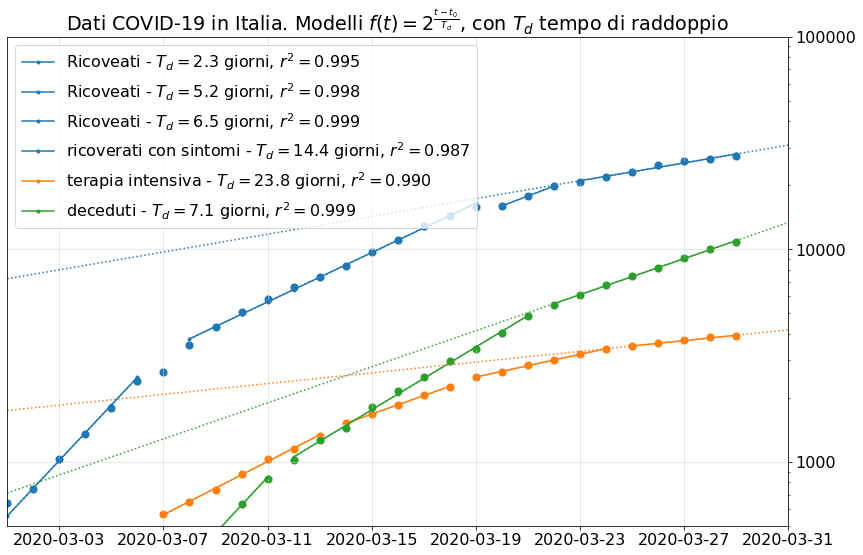

In [7]:
_, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (500, 100000)})
# _ = covid19.plot.add_events(ax, linestyle=':', offset=11, color='grey')

#ax.axvline(np.datetime64('2020-03-06'), linestyle=':', color=PALETTE[0])
#ax.axvline(np.datetime64('2020-03-11'), linestyle=':', color=PALETTE[1])

#ax.axvline(np.datetime64('2020-03-19'), linestyle=':', color=PALETTE[0])
#ax.axvline(np.datetime64('2020-03-22'), linestyle=':', color=PALETTE[1])

covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_1'], label='Ricoveati', color=PALETTE[0])
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_2'], label='Ricoveati', color=PALETTE[0])
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_3'], label='Ricoveati', color=PALETTE[0])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_1'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_2'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_3'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_4'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['deceduti_1'], color=sns.color_palette()[2])
covid19.plot.plot_fit(ax, fits['deceduti_2'], color=sns.color_palette()[2])
for kind, color in zip(['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti'], sns.color_palette()):
    covid19.plot.plot(ax, data_italy[kind], fits[kind], label=kind.replace('_', ' '), extrapolate=EXTRAPOLATE, color=color, date_interval=4)

_ = ax.set(title=r'Dati COVID-19 in Italia. Modelli $f(t) = 2 ^ \frac{t - t_0}{T_d}$, con $T_d$ tempo di raddoppio')
_ = ax.yaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.xaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.yaxis.tick_right()
_ = ax.set(xlim=EXTRAPOLATE)
#_ = ax.legend(loc='upper left')


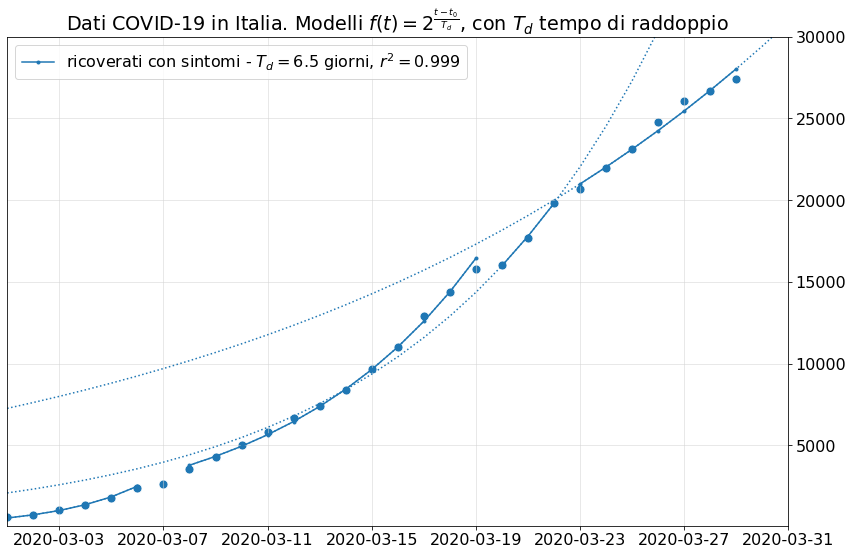

In [8]:
_, ax = plt.subplots(subplot_kw={'yscale': 'linear', 'ylim': (80, 30000)})
# _ = covid19.plot.add_events(ax, linestyle=':', offset=17, color='grey')

covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_1'], color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_2'], color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_3'], label='ricoverati con sintomi', extrapolate=EXTRAPOLATE, color=sns.color_palette()[0])
#covid19.plot.plot_fit(ax, fits['terapia_intensiva_1'], color=sns.color_palette()[1])
#covid19.plot.plot_fit(ax, fits['terapia_intensiva_2'], color=sns.color_palette()[1])
#covid19.plot.plot_fit(ax, fits['terapia_intensiva_3'], color=sns.color_palette()[1])
#covid19.plot.plot_fit(ax, fits['deceduti_1'], color=sns.color_palette()[1])
#covid19.plot.plot_fit(ax, fits['deceduti_2'], color=sns.color_palette()[1])
for kind, color in zip(['ricoverati_con_sintomi'], sns.color_palette()):
    covid19.plot.plot(ax, data_italy[kind], fits[kind], extrapolate=EXTRAPOLATE, color=color, date_interval=4)

_ = ax.set(title=r'Dati COVID-19 in Italia. Modelli $f(t) = 2 ^ \frac{t - t_0}{T_d}$, con $T_d$ tempo di raddoppio')
_ = ax.yaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.xaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.yaxis.tick_right()
_ = ax.set(xlim=EXTRAPOLATE)
_ = ax.legend(loc='upper left')


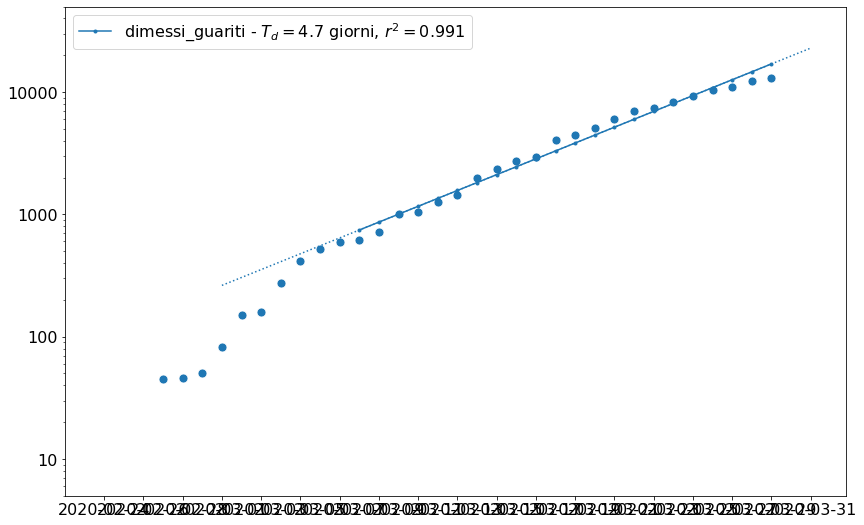

In [9]:
_, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (5, 50000)})
kind = 'dimessi_guariti'
covid19.plot.plot(ax, data_italy[kind], fits[kind], label=kind, extrapolate=EXTRAPOLATE, color=color)


## estimates

In [10]:
kinds = ['deceduti', 'terapia_intensiva', 'ricoverati_con_sintomi', 'dimessi_guariti']
datetime_expected = '2020-03-28'
expected_values = []
for kind in kinds:
    expected_values.append(int(round(fits[kind].predict(datetime_expected))))
print(', '.join(f'{k}: {v}' for v, k in zip(expected_values, kinds)))

deceduti: 9959, terapia_intensiva: 3826, ricoverati_con_sintomi: 26712, dimessi_guariti: 14626


In [11]:
for key, value in list(fits.items()):
    print(f'{key} {" " * (26 - len(key))}{str(value)}')

dimessi_guariti            T_d=4.66, t_0='2020-01-23', r^2=0.991 start='2020-03-08', stop='2020-03-29'
totale_casi_1              T_d=2.11, t_0='2020-02-07', r^2=0.995 start='2020-02-24', stop='2020-02-29'
totale_casi                T_d=3.27, t_0='2020-01-26', r^2=1.000 start='2020-03-01', stop='2020-03-09'
ricoverati_con_sintomi_1   T_d=2.31, t_0='2020-02-08', r^2=0.995 start='2020-02-24', stop='2020-03-06'
ricoverati_con_sintomi_2   T_d=5.19, t_0='2020-01-06', r^2=0.998 start='2020-03-08', stop='2020-03-19'
ricoverati_con_sintomi_3   T_d=6.47, t_0='2019-12-20', r^2=0.999 start='2020-03-20', stop='2020-03-22'
terapia_intensiva_1        T_d=2.56, t_0='2020-02-12', r^2=0.996 start='2020-02-24', stop='2020-03-06'
terapia_intensiva_2        T_d=4.81, t_0='2020-01-23', r^2=0.999 start='2020-03-07', stop='2020-03-13'
terapia_intensiva_3        T_d=6.92, t_0='2019-12-31', r^2=1.000 start='2020-03-14', stop='2020-03-18'
terapia_intensiva_4        T_d=11.28, t_0='2019-11-12', r^2=0.999 start='

In [12]:
data_italy.tail()

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,variazione_ricoverati_con_sintomi,variazione_terapia_intensiva,variazione_deceduti
data,,,,,,,,,,,,,,,,
2020-03-25,ITA,23112,3489,26601,30920,57521,3491,9362,7503,74386,324445,NaN,NaN,1175.0,93.0,683.0
2020-03-26,ITA,24753,3612,28365,33648,62013,4492,10361,8165,80539,361060,pd-IT-0007,pd-EN-0007,1641.0,123.0,662.0
2020-03-27,ITA,26029,3732,29761,36653,66414,4401,10950,9134,86498,394079,NaN,NaN,1276.0,120.0,969.0
2020-03-28,ITA,26676,3856,30532,39533,70065,3651,12384,10023,92472,429526,NaN,NaN,647.0,124.0,889.0
2020-03-29,ITA,27386,3906,31292,42588,73880,3815,13030,10779,97689,454030,pd-IT-0009,pd-EN-0009,710.0,50.0,756.0
